In [57]:
using Revise

using ramnet
using ramnet.Encoders
using ramnet.Models: BleachingDiscriminator, predict_bleached, predict_response
using ramnet.Utils: accuracy, ambiguity

using Random
using DataFrames
using StatsBase: sample, ProbabilityWeights
using StatsPlots
pyplot()

Plots.PyPlotBackend()

In [67]:
sample(MersenneTwister(), [-1, 1], ProbabilityWeights([0.1, 0.9]), 10)

10-element Array{Int64,1}:
 -1
  1
  1
  1
  1
  1
  1
  1
  1
  1

# WNN for Real Valued Inputs

In [2]:
thermo = Thermometer(0.0, 1.0, 10)

Thermometer(0.0, 1.0, 10)

In [5]:
encode(thermo, [0.1 0.7; 0.0 1.0])

2×20 Array{Bool,2}:
 1  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1

In [49]:
rand((1, -1), 5)

5-element Array{Int64,1}:
  1
 -1
  1
  1
 -1

In [26]:
[1, 2, 3] .* [4, 5, 6]

3-element Array{Int64,1}:
  4
 10
 18

## Can WNN handle binary classification in 2D euclidean space? 

In [68]:
function linearly_separable_dataset(N; seed=nothing)
    rng = isnothing(seed) ? MersenneTwister() : MersenneTwister(seed) 
    intercepts = rand(rng, 2)
    a, b = -intercepts[2]/intercepts[1], intercepts[2]

    X = rand(rng, Float64, (N, 2))
    y = [x_2 >= a*x_1 + b ? 1 : -1 for (x_1, x_2) in eachrow(X)]

    return X, y
end

function add_noise(y; level=0.0, seed=nothing)
    rng = isnothing(seed) ? MersenneTwister() : MersenneTwister(seed)
    y .* sample([-1, 1], ProbabilityWeights([level, 1-level]), length(y))
end

add_noise (generic function with 1 method)

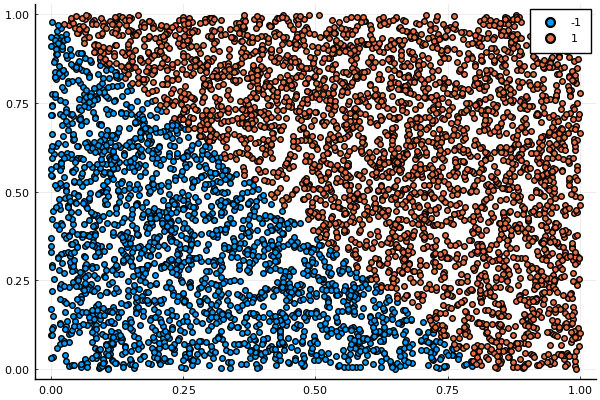

In [3]:
X, y = linearly_separable_dataset(5000; seed=3)

@df DataFrame(X_1 = X[:, 1], X_2=X[:, 2], y=y) scatter(
    :X_1,
    :X_2,
    group=:y
)

In [111]:
model = MultiDiscriminatorClassifier{Int64,BleachingDiscriminator}(120, 30; seed=1)

enc = Thermometer(0.0, 1.0, 60)

X_train, y_train = encode(enc, X[1:3500, :]), add_noise(y[1:3500]; level=0.2, seed=1) 
X_test, y_test = encode(enc, X[3501:end, :]), y[3501:end]

train!(model, X_train, y_train)

b=16
@show accuracy(predict(model, X_test; b), y_test)
@show ambiguity(values(predict_response(model, X_test; b))...);

accuracy(predict(model, X_test; b), y_test) = 0.896
ambiguity(values(predict_response(model, X_test; b))...) = 0.142


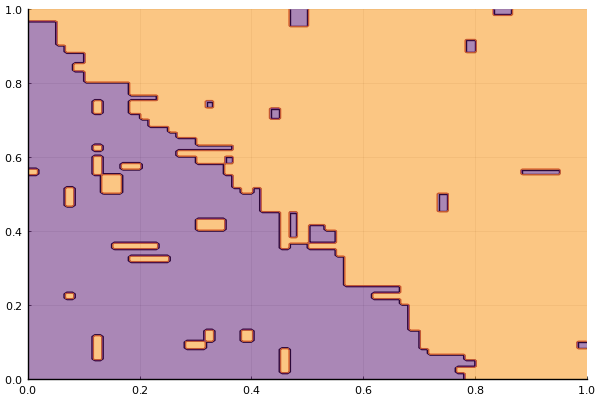

In [90]:
contourf(
    range(0.0, 1.0, step=0.005),
    range(0.0, 1.0, step=0.005),
    (x_1, x_2) -> predict_bleached(model, encode(enc, [x_1, x_2])),
    levels=1,
    colorbar=false,
    fillalpha=0.5
)

It's looking like dynamic bleaching is the better tool to deal with noise if compared with a fixed bleaching threshold.